In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 78.10%
Success Probability Vector:
tensor([0.8989, 0.0029, 0.0385, 0.0048, 0.0046, 0.0019, 0.0020, 0.0027, 0.0353,
        0.0085], device='cuda:0')
Class 2 - Accuracy: 86.00%
Success Probability Vector:
tensor([3.2964e-03, 9.4865e-01, 8.5005e-04, 1.0260e-03, 7.3003e-04, 9.6496e-04,
        1.6061e-03, 8.3644e-04, 9.5555e-03, 3.2481e-02], device='cuda:0')
Class 3 - Accuracy: 71.70%
Success Probability Vector:
tensor([0.0224, 0.0011, 0.8952, 0.0173, 0.0161, 0.0160, 0.0210, 0.0064, 0.0031,
        0.0013], device='cuda:0')
Class 4 - Accuracy: 58.60%
Success Probability Vector:
tensor([0.0059, 0.0020, 0.0378, 0.7362, 0.0225, 0.1194, 0.0305, 0.0328, 0.0062,
        0.0068], device='cuda:0')
Class 5 - Accuracy: 70.70%
Success Probability Vector:
tensor([4.6188e-03, 8.9982e-04, 2.2019e-02, 2.2968e-02, 8.7984e-01, 1.3015e-02,
        1.4764e-02, 4.0045e-02, 1.0962e-03, 7.3397e-04], device='cuda:0')

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.2616688098250812e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.4830135537774436e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.3358864719382134e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 1.124600032476259e-15, Min = 0.9999998807907104, Max = 1.0
Class 3 (Successful): Mean = 1.0, Variance = 1.4687196610342905e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.7259637788736583e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.7429552597955796e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.307536279193612e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.313397006034783e-15, Min =

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[86.0, 71.0, 73.0, 87.0, 85.0, 81.0, 88.0, 75.0, 85.0, 84.0, 82.0, 77.0, 63.0, 78.0, 76.0, 87.0, 72.0, 78.0, 81.0, 85.0, 85.0, 75.0, 74.0, 85.0, 80.0, 70.0, 59.0, 80.0, 74.0, 79.0, 79.0, 69.0, 76.0, 70.0, 86.0, 87.0, 65.0, 80.0, 83.0, 71.0, 79.0, 69.0, 77.0, 69.0, 83.0, 57.0, 72.0, 85.0, 73.0, 80.0, 92.0, 83.0, 74.0, 89.0, 85.0, 91.0, 62.0, 86.0, 76.0, 82.0, 79.0, 82.0, 94.0, 88.0, 77.0, 74.0, 77.0, 94.0, 74.0, 82.0, 68.0, 89.0, 82.0, 75.0, 74.0, 68.0, 82.0, 61.0, 67.0, 59.0, 53.0, 84.0, 65.0, 81.0, 80.0, 56.0, 76.0, 78.0, 82.0, 73.0, 77.0, 71.0, 71.0, 72.0, 84.0, 76.0, 71.0, 83.0, 84.0, 81.0]
Before min/max/mean/std of accuracy
53.0 94.0 77.29 8.43


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {1: 500}, 1: {2: 500}, 2: {2: 250, 4: 250}, 3: {7: 500}, 4: {3: 250, 8: 250}, 5: {0: 250, 6: 250}, 6: {6: 250, 8: 250}, 7: {3: 250, 8: 250}, 8: {9: 500}, 9: {6: 250, 9: 250}, 10: {2: 250, 9: 250}, 11: {4: 250, 8: 250}, 12: {0: 250, 3: 250}, 13: {2: 250, 6: 250}, 14: {2: 250, 7: 250}, 15: {7: 250, 9: 250}, 16: {3: 250, 6: 250}, 17: {4: 250, 8: 250}, 18: {7: 250, 9: 250}, 19: {1: 500}, 20: {8: 250, 9: 250}, 21: {5: 250, 6: 250}, 22: {0: 250, 9: 250}, 23: {0: 250, 7: 250}, 24: {0: 250, 6: 250}, 25: {1: 250, 5: 250}, 26: {3: 250, 4: 250}, 27: {4: 250, 8: 250}, 28: {1: 250, 3: 250}, 29: {2: 250, 7: 250}, 30: {1: 250, 4: 250}, 31: {4: 250, 5: 250}, 32: {2: 250, 7: 250}, 33: {2: 250, 4: 250}, 34: {1: 250, 7: 250}, 35: {6: 250, 8: 250}, 36: {2: 250, 4: 250}, 37: {2: 250, 8: 250}, 38: {2: 250, 9: 250}, 39: {0: 250, 4: 250}, 40: {1: 250, 5: 250}, 41: {2: 250, 5: 250}, 42: {2: 250, 8: 250}, 43: {3: 250, 7: 250}, 44: {0: 250, 7: 250}, 45: 

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {1: 100}, 1: {2: 100}, 2: {2: 50, 4: 50}, 3: {7: 100}, 4: {3: 50, 8: 50}, 5: {0: 50, 6: 50}, 6: {6: 50, 8: 50}, 7: {3: 50, 8: 50}, 8: {9: 100}, 9: {6: 50, 9: 50}, 10: {2: 50, 9: 50}, 11: {4: 50, 8: 50}, 12: {0: 50, 3: 50}, 13: {2: 50, 6: 50}, 14: {2: 50, 7: 50}, 15: {7: 50, 9: 50}, 16: {3: 50, 6: 50}, 17: {4: 50, 8: 50}, 18: {7: 50, 9: 50}, 19: {1: 100}, 20: {8: 50, 9: 50}, 21: {5: 50, 6: 50}, 22: {0: 50, 9: 50}, 23: {0: 50, 7: 50}, 24: {0: 50, 6: 50}, 25: {1: 50, 5: 50}, 26: {3: 50, 4: 50}, 27: {4: 50, 8: 50}, 28: {1: 50, 3: 50}, 29: {2: 50, 7: 50}, 30: {1: 50, 4: 50}, 31: {4: 50, 5: 50}, 32: {2: 50, 7: 50}, 33: {2: 50, 4: 50}, 34: {1: 50, 7: 50}, 35: {6: 50, 8: 50}, 36: {2: 50, 4: 50}, 37: {2: 50, 8: 50}, 38: {2: 50, 9: 50}, 39: {0: 50, 4: 50}, 40: {1: 50, 5: 50}, 41: {2: 50, 5: 50}, 42: {2: 50, 8: 50}, 43: {3: 50, 7: 50}, 44: {0: 50, 7: 50}, 45: {3: 50, 5: 50}, 46: {5: 50, 8: 50}, 47: {1: 50, 9: 50}, 48: {3: 50, 7: 50}, 49: {

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.1191,  0.1040, -0.0203, -0.1905, -0.0244, -0.0695,  0.0058, -0.0732,
         0.2238,  0.1826], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([62.9186, 60.6473, 61.0295, 64.3308, 63.1529, 60.7312, 67.8197, 63.5013,
        66.1687, 72.7084], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0509, -0.1747, -0.1701, -0.1214, -0.2054, -0.1227, -0.1214,
          0.0270, -0.0579],
        [-0.0509,  1.0000, -0.1969, -0.1670, -0.1320, -0.1191, -0.1753, -0.1494,
         -0.0927,  0.1065],
        [-0.1747, -0.1969,  1.0000, -0.0894, -0.0211, -0.0202, -0.0995, -0.0195,
         -0.1589, -0.1768],
        [-0.1701, -0.1670, -0.0894,  1.0000, -0.0294, -0.0071, -0.0642, -0.0650,
         -0.1676, -0.2206],
        [-0.1214, -0.1320, -0.0211, -0.0294,  1.0000, -0.0625, -0.0965, -0.1277,
         -0.1057, -0.2

Weight norm of each class part of classifier
tensor([7.9321, 7.7876, 7.8121, 8.0206, 7.9469, 7.7930, 8.2353, 7.9688, 8.1344,
        8.5269], device='cuda:0', grad_fn=<SqrtBackward0>)


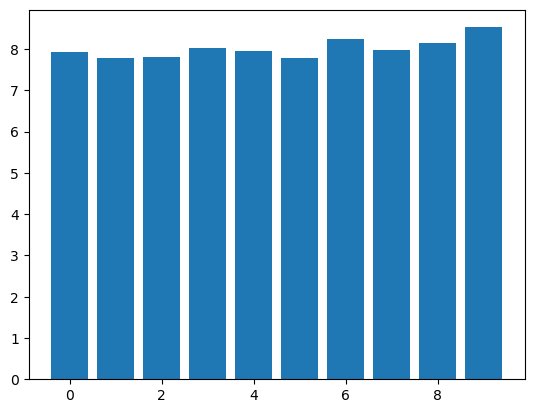

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

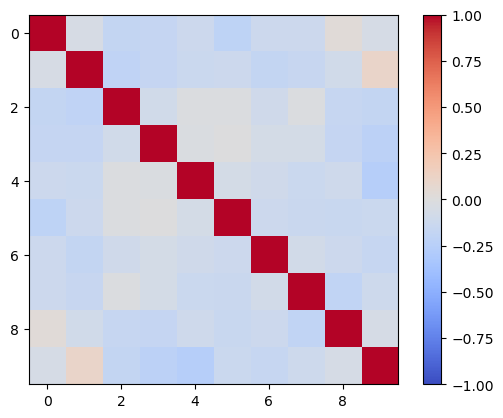

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.87377423, 1: 0.9154562, 2: 0.8345557, 3: 0.85824853, 4: 0.8537975, 5: 0.86228615, 6: 0.8994051, 7: 0.90585345, 8: 0.92578185, 9: 0.89922523}
-------------------VAR-------------------
{0: 0.02195435, 1: 0.018260136, 2: 0.02197528, 3: 0.018761024, 4: 0.017309433, 5: 0.015862701, 6: 0.017854556, 7: 0.017604664, 8: 0.018275086, 9: 0.022868691}


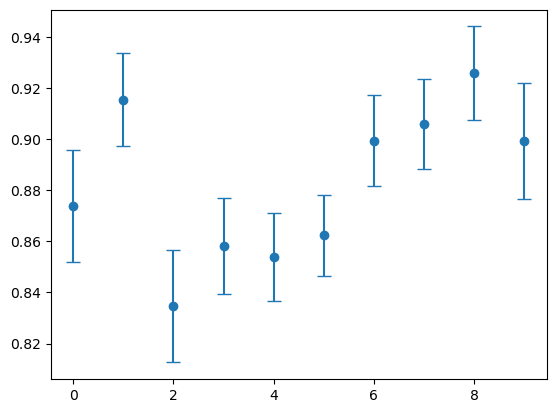

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([2.1746e-02, 0.0000e+00, 7.5797e-02, 3.0984e-03, 8.4017e-03, 0.0000e+00,
        1.8200e-02, 5.1595e-02, 1.2297e-02, 0.0000e+00, 1.8050e-03, 4.5203e-02,
        6.0329e-03, 9.8145e-03, 7.5816e-04, 1.2215e-02, 2.8067e-03, 8.1232e-02,
        2.9035e-03, 4.0740e-03, 0.0000e+00, 8.9714e-02, 3.2396e-03, 3.1077e-03,
        2.7298e-02, 2.1955e-02, 5.6017e-02, 9.8775e-02, 9.3341e-06, 2.2438e-03,
        1.0970e-02, 6.8069e-04, 1.4876e-01, 2.0930e-05, 4.1994e-03, 5.1858e-05,
        0.0000e+00, 0.0000e+00, 3.7299e-04, 0.0000e+00, 1.7669e-01, 0.0000e+00,
        5.3238e-02, 6.4757e-03, 2.4640e-03, 1.4521e-01, 1.3292e-04, 6.7171e-02,
        3.2701e-03, 5.3645e-03, 2.7237e-03, 5.4676e-03, 3.7077e-03, 0.0000e+00,
        3.9920e-02, 7.4554e-04, 5.8687e-02, 2.5498e-02, 1.2680e-02, 9.6771e-04,
        8.1323e-02, 3.8013e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7541e-02,
        2.0662e-03, 3.5274e-04, 2.0027e-

# Cosine Similarity of Centroid Vectors

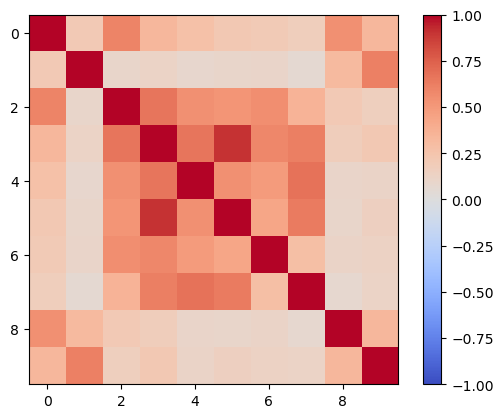

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.         0.21031447 0.60097146 0.33056635 0.27298552 0.21382087
  0.20146    0.16766292 0.5437386  0.33150765]
 [0.21031447 1.         0.09797718 0.12141105 0.07993171 0.10063253
  0.10683768 0.06196167 0.31431493 0.6157136 ]
 [0.60097146 0.09797718 1.         0.6565172  0.54541403 0.51759285
  0.5472659  0.357211   0.20864607 0.15823437]
 [0.33056635 0.12141105 0.6565172  1.         0.6574518  0.9010622
  0.58564925 0.61839867 0.17427948 0.21871252]
 [0.27298552 0.07993171 0.54541403 0.6574518  0.9999999  0.54518044
  0.48847836 0.6743029  0.10929815 0.11068597]
 [0.21382087 0.10063253 0.51759285 0.9010622  0.54518044 0.9999998
  0.43252867 0.63480306 0.10134983 0.15125313]
 [0.20146    0.10683768 0.5472659  0.58564925 0.48847836 0.43252867
  0.99999994 0.28426895 0.11481245 0.13265635]
 [0.16766292 0.06196167 0.357211   0.61839867 0.6743029  0.63480306
  0.28426895 1.         0.07671767 0.12084102]
 [0.5437386  0.31431493 0.20864607 0.17427948 0.10929815 0

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.7133, 0.8093, 0.6864, 0.5021, 0.6515, 0.6414, 0.7313, 0.7218, 0.7882,
        0.7045], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.7133, 0.8093, 0.6864, 0.5021, 0.6515, 0.6414, 0.7313, 0.7218, 0.7882,
        0.7045], device='cuda:0', grad_fn=<DiagonalBackward0>)


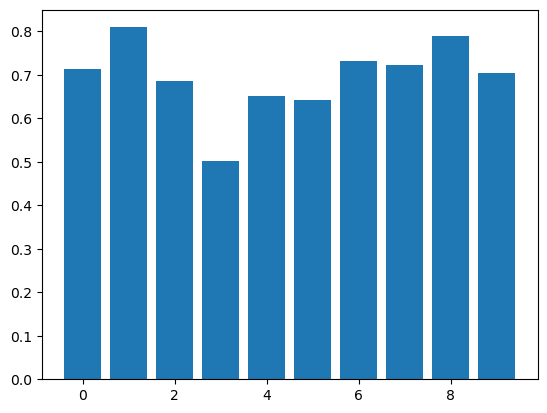

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()